In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import sys
sys.path.append('../..')
from contrib.DMI.SST.data import *
from contrib.DMI.SST.load_data import *
from src.utils import *
from src.models import *


import matplotlib.pyplot as plt
import torch
import itertools

lon_min = -10
lon_max = 30
lat_min = 48
lat_max = 66

datamodule_coarse = BaseDataModule(input_da=load_data(path_obs="/DATASET/mbeauchamp/DMI/training_dataset/DMI-L3S_GHRSST-SSTsubskin-night_SST_UHR_NRT-NSEABALTIC.nc",
                                                      path_tgt="/DATASET/mbeauchamp/DMI/training_dataset/DMI-L4_GHRSST-SSTfnd-DMI_OI-NSEABALTIC.nc"),
                            domains={'train': {'time': slice('2019-05-01', '2020-12-31',)},
                                     'val': {'time': [ slice('2021-01-01', '2021-01-31',),
                                                       slice('2021-04-01', '2021-04-30',),
                                                       slice('2021-07-01', '2021-07-31',),
                                                       slice('2021-10-01', '2021-10-31',) ]},
                                     'test': {'time': slice('2021-06-01', '2021-06-30',)}},
                            xrds_kw={'patch_dims': {'time': 7, 'lat': 90, 'lon': 200},
                                     'strides': {'time': 1, 'lat': 90, 'lon': 200},
                                     'strides_test': {'time': 1, 'lat': 90, 'lon': 200},
                                     'domain_limits':  dict(lon=slice(lon_min, lon_max,),
                                                            lat=slice(lat_min, lat_max,)),
                                     },
                            dl_kw={'batch_size': 2, 'num_workers': 0},
                            res=0.2,
                            resize_factor=10,
                            pads=[False,False,True],
                            norm_stats =[283.8052,4.2381434])
datamodule_coarse.setup()
data_loader_coarse = datamodule_coarse.train_dataloader()
test_dataloader_coarse = datamodule_coarse.test_dataloader()

/homes/m19beauc/miniconda3/envs/4dvarnet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ValueError: cannot rename 'sea_surface_temperature' because it is not a variable or coordinate in this dataset

In [3]:
datamodule = BaseDataModule_wcoarse_wgeo(input_da=load_data_wcoarse_wgeo(path_obs="/DATASET/mbeauchamp/DMI/training_dataset/DMI-L3S_GHRSST-SSTsubskin-night_SST_UHR_NRT-NSEABALTIC.nc",
                                                      path_tgt="/DATASET/mbeauchamp/DMI/training_dataset/DMI-L3S_GHRSST-SSTsubskin-night_SST_UHR_NRT-NSEABALTIC.nc",     
                                                      path_oi="/DATASET/mbeauchamp/DMI/training_dataset/DMI-L4_GHRSST-SSTfnd-DMI_OI-NSEABALTIC.nc",
                                                      path_coarse="/DATASET/mbeauchamp/DMI/training_dataset/DMI-L3S_GHRSST-SSTsubskin-night_SST_UHR_NRT-NSEABALTIC_w4DVarNet_coarse.nc",
                                                      path_topo="/DATASET/mbeauchamp/DMI/training_dataset/DMI-TOPO_NSEABALTIC.nc",
                                                      path_fgstd="/DATASET/mbeauchamp/DMI/training_dataset/DMI-FGSTD_NSEABALTIC.nc"),
                            domains={'train': {'time': slice('2019-05-01', '2020-12-31',)},
                                     'val': {'time': [ slice('2021-01-01', '2021-01-31',),
                                                       slice('2021-04-01', '2021-04-30',),
                                                       slice('2021-07-01', '2021-07-31',),
                                                       slice('2021-10-01', '2021-10-31',) ]},
                                     'test': {'time': slice('2021-06-01', '2021-06-30',)}},
                            xrds_kw={'patch_dims': {'time': 7, 'lat': 240, 'lon': 240},
                                     'strides': {'time': 1, 'lat': 5, 'lon': 5},
                                     'strides_test': {'time': 1, 'lat': 200, 'lon': 200},
                                     'domain_limits':  dict(lon=slice(lon_min, lon_max,),
                                                            lat=slice(lat_min, lat_max,)),
                                     },
                            dl_kw={'batch_size': 2, 'num_workers': 0},
                            res=0.02,
                            pads=[False,False,True],
                            norm_stats =[-0.015420883207237286,0.4562528584789277])
datamodule.setup()
data_loader = datamodule.train_dataloader()
test_dataloader = datamodule.test_dataloader()

/homes/m19beauc/4dvarnet-starter/Notebooks/Notebook_DMI/../../contrib/DMI/SST/load_data.py:83: RuntimeWarning: invalid value encountered in log
  'topo':(('lat','lon'),np.log(-1.*topo.topo.data+1)),
/homes/m19beauc/4dvarnet-starter/Notebooks/Notebook_DMI/../../contrib/DMI/SST/data.py:139: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  da_dims = dict(zip(self.da.dims.keys(), self.da.dims.values()))


In [4]:
coords = datamodule_coarse.test_ds.get_coords()
# datamodule.train_ds[0].input has shape (15, 240, 240)
p = xr.Dataset(data_vars={'sst':(('time','lat','lon'),datamodule_coarse.test_ds[10].tgt)},
           coords={'time':np.arange(7),
                   'lon':coords[10].lon,
                   'lat':coords[10].lat}).sst.plot(transform=ccrs.PlateCarree(),
                                                   col='time',col_wrap=7,
                                                   aspect=datamodule.input_da.dims['lon'] / datamodule.input_da.dims['lat'], 
                                                   subplot_kws={'projection': ccrs.Orthographic(0, 45)})
for ax in p.axes.flat:
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
    ax.set_global()
    ax.gridlines()
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

NameError: name 'datamodule_coarse' is not defined

# 0. Control of the coarse 4DVarNet approximation

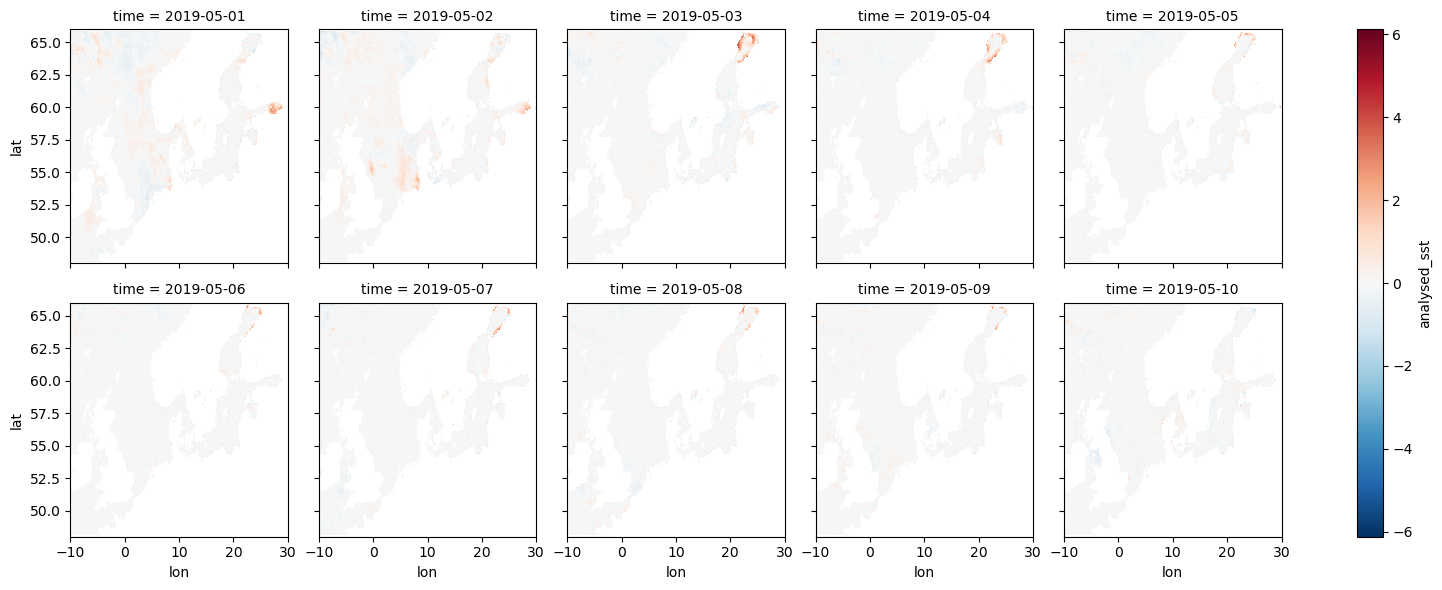

In [6]:
coarse = xr.open_dataset("/DATASET/mbeauchamp/DMI/training_dataset/DMI-L4_GHRSST-SSTfnd-4DVarNet_coarse-NSEABALTIC.nc")
coarse = xr.open_dataset("/DATASET/mbeauchamp/DMI/training_dataset/DMI-L3S_GHRSST-SSTsubskin-night_SST_UHR_NRT-NSEABALTIC_w4DVarNet_coarse.nc")
coarse = coarse.rename_vars({'analysed_sst_LR':'analysed_sst'})

high = xr.open_dataset("/DATASET/mbeauchamp/DMI/training_dataset/DMI-L4_GHRSST-SSTfnd-DMI_OI-NSEABALTIC.nc")

anom = coarse-high

anom.isel(time=slice(20,30)).analysed_sst.plot(col='time',col_wrap=5)

In [7]:
anom_mean_sst = anom.analysed_sst.mean(dim='time')

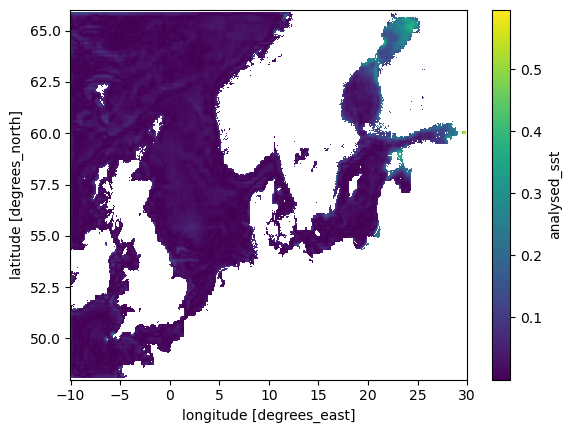

In [8]:
np.abs(anom_mean_sst).plot()

In [ ]:
# Compare 4DVarNet_LR_on_HR to OI_HR 

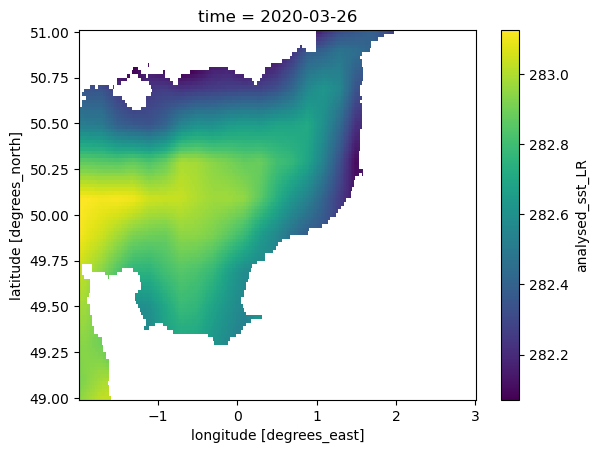

In [12]:
import xarray as xr
import matplotlib.pyplot as plt 
data_coarse=xr.open_dataset('/DATASET/mbeauchamp/DMI/training_dataset/DMI-L3S_GHRSST-SSTsubskin-night_SST_UHR_NRT-NSEABALTIC_w4DVarNet_coarse.nc')
data_coarse.sel(lon=slice(-2,3),lat=slice(49,51)).isel(time=350).analysed_sst_LR.plot()

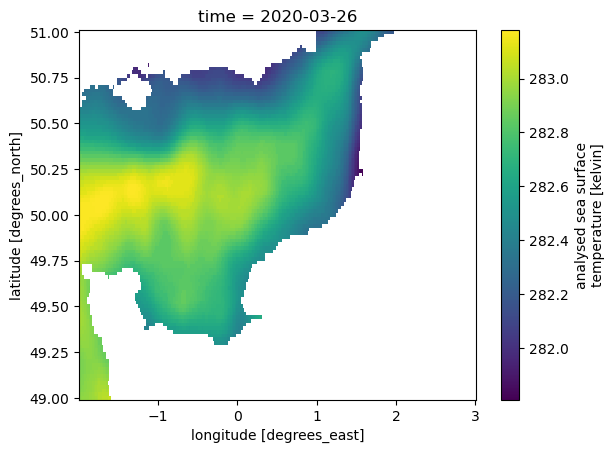

In [13]:
data=xr.open_dataset('/DATASET/mbeauchamp/DMI/training_dataset/DMI-L4_GHRSST-SSTfnd-DMI_OI-NSEABALTIC.nc')
data.sel(lon=slice(-2,3),lat=slice(49,51)).isel(time=350).analysed_sst.plot()

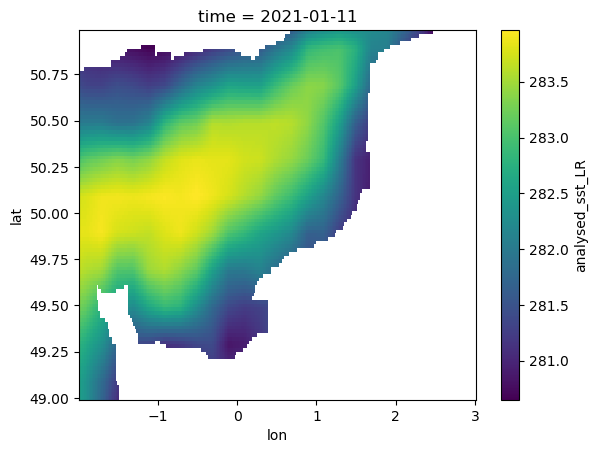

In [6]:
import xarray as xr
import matplotlib.pyplot as plt 
data_coarse=xr.open_dataset('/DATASET/mbeauchamp/DMI/validation_dataset/DMI-L3S_GHRSST-SSTsubskin-night_SST_UHR_NRT-NSEABALTIC_validation_s0_w4DVarNet_coarse.nc')
data_coarse.sel(lon=slice(-2,3),lat=slice(49,51)).isel(time=10).analysed_sst_LR.plot()

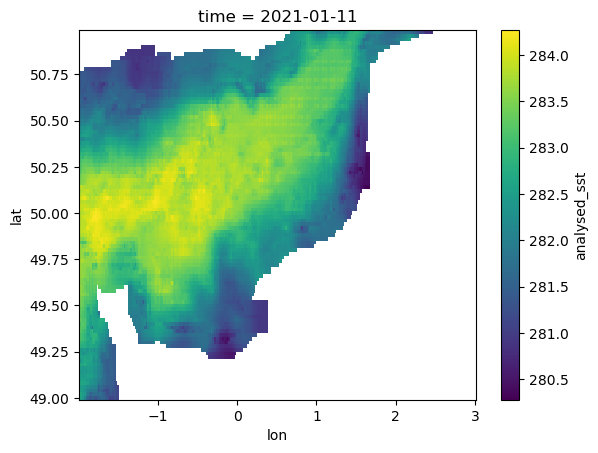

In [4]:
data=xr.open_dataset('/DATASET/mbeauchamp/DMI/validation_dataset/DMI-L4_GHRSST-SSTfnd-DMI_OI-NSEABALTIC_2021_validation.nc')
data.sel(lon=slice(-2,3),lat=slice(49,51)).isel(time=10).analysed_sst.plot()

# 1. Display the patch strategy

## 1.1 Plot the training batches

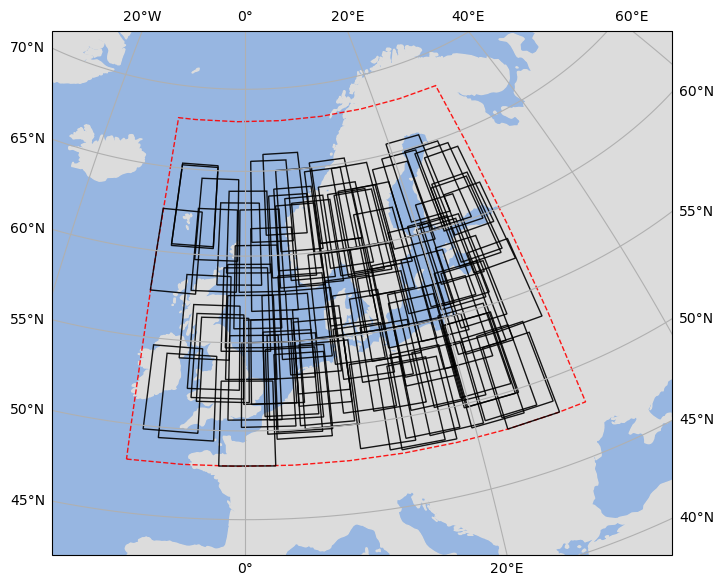

In [4]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from random import sample 

map_proj = ccrs.Orthographic(0, 45)
map_proj._threshold /= 100.

fig, ax = plt.subplots(figsize=(8,7),
                       subplot_kw=dict(projection=map_proj))
ax.add_feature(cartopy.feature.OCEAN, zorder=0)
ax.add_feature(cartopy.feature.LAND, color='gainsboro',zorder=0, edgecolor='black')
ax.set_global()
ax.gridlines(draw_labels=True)
ax.set_extent([-15, 35, 43, 71], crs=ccrs.PlateCarree())
lon_min = -10
lon_max = 30
lat_min = 48
lat_max = 66

coords = datamodule.train_ds.get_coords()

# Baltic
ax.add_patch(mpatches.Rectangle(xy=[lon_min, lat_min], width=40, height=20,
                                    edgecolor='red',
                                    linestyle="dashed",
                                    alpha=0.9,
                                    facecolor="none",
                                    transform=ccrs.PlateCarree()))

for i in range(0,100):
    # test1
    ax.add_patch(mpatches.Rectangle(xy=[coords[i].lon[0], coords[i].lat[0]], 
                                    width=datamodule.xrds_kw['patch_dims']['lon']*0.02,
                                    height=datamodule.xrds_kw['patch_dims']['lat']*0.02,
                                    edgecolor='black',
                                    facecolor="none",
                                    alpha=0.9,
                                    transform=ccrs.PlateCarree()))      
plt.show()

## 1.2 Plot the testing batches

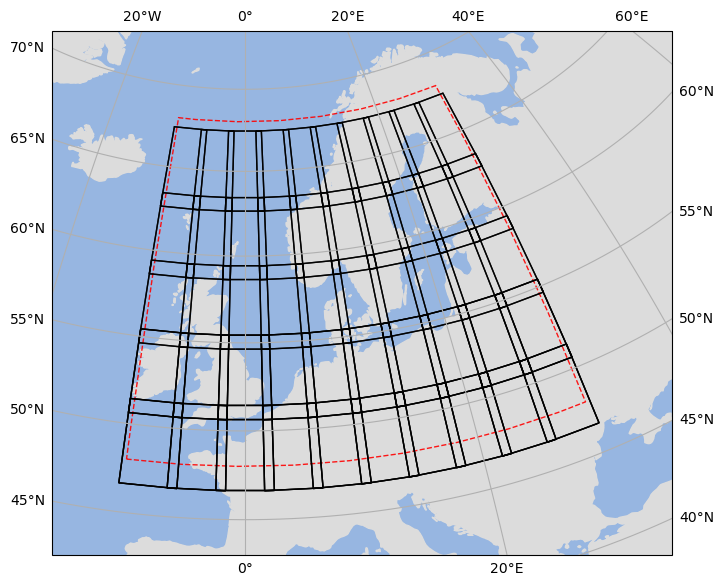

In [29]:
fig, ax = plt.subplots(figsize=(8,7),
                       subplot_kw=dict(projection=map_proj))
ax.add_feature(cartopy.feature.OCEAN, zorder=0)
ax.add_feature(cartopy.feature.LAND, color='gainsboro', zorder=0, edgecolor='black')
ax.set_global()
ax.gridlines(draw_labels=True)
ax.set_extent([-15, 35, 43, 71], crs=ccrs.PlateCarree())
lon_min = -10
lon_max = 30
lat_min = 48
lat_max = 66

coords = datamodule.test_ds.get_coords()

# Baltic
ax.add_patch(mpatches.Rectangle(xy=[lon_min, lat_min], width=40, height=20,
                                    edgecolor='red',
                                    linestyle="dashed",
                                    alpha=0.9,
                                    facecolor="none",
                                    transform=ccrs.PlateCarree()))

for i in range(120):
    ax.add_patch(mpatches.Rectangle(xy=[coords[i].lon[0], coords[i].lat[0]],
                                    width=datamodule.xrds_kw['patch_dims']['lon']*0.02,
                                    height=datamodule.xrds_kw['patch_dims']['lat']*0.02,
                                    edgecolor='black',
                                    facecolor="none",
                                    alpha=0.9,
                                    transform=ccrs.PlateCarree()))        

## 1.3 Plot the areas of interest

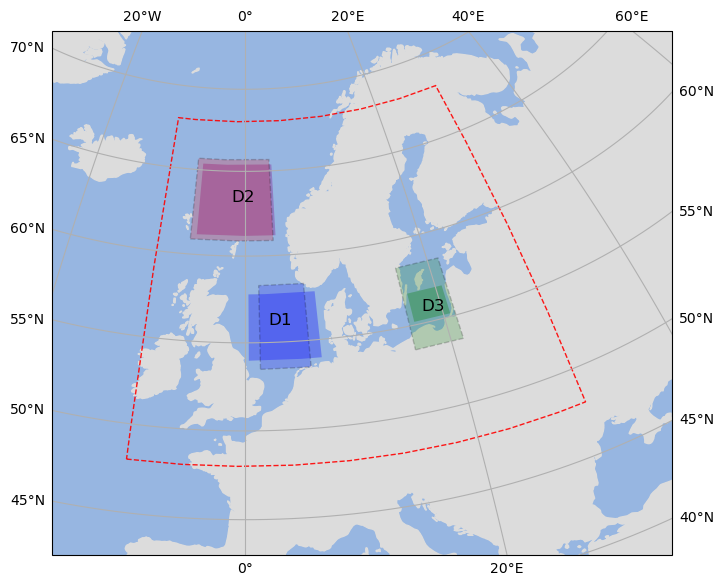

In [30]:
fig, ax = plt.subplots(figsize=(8,7),
                       subplot_kw=dict(projection=map_proj))
ax.add_feature(cartopy.feature.OCEAN, zorder=0)
ax.add_feature(cartopy.feature.LAND, color='gainsboro',zorder=0, edgecolor='black')
ax.set_global()
ax.gridlines(draw_labels=True)
ax.set_extent([-15, 35, 43, 71], crs=ccrs.PlateCarree())
lon_min = -10
lon_max = 30
lat_min = 48
lat_max = 66

coords = datamodule.test_ds.get_coords()

# Baltic
ax.add_patch(mpatches.Rectangle(xy=[lon_min, lat_min], width=40, height=20,
                                    edgecolor='red',
                                    linestyle="dashed",
                                    alpha=0.9,
                                    facecolor="none",
                                    transform=ccrs.PlateCarree()))

# Domain #1
ax.add_patch(mpatches.Rectangle(xy=[0.38,53.98], width=7, height=3.8,
                                    facecolor='blue',
                                    alpha=0.3,
                                    transform=ccrs.PlateCarree()))  
ax.text(0.38+2, 53.98+2, "D1", fontsize=12,transform=ccrs.PlateCarree())
# training_DM1 (lon:[1.48,6.28], lat:[53.48,58.28])
ax.add_patch(mpatches.Rectangle(xy=[1.48,53.48], width=4.8, height=4.8,
                                    facecolor='blue',
                                    linestyle="dashed",
                                    edgecolor='black',
                                    alpha=0.2,
                                    transform=ccrs.PlateCarree()))  
                                    
# Domain #2
ax.add_patch(mpatches.Rectangle(xy=[-5.62,61.18], width=9.2, height=4.2,
                                    facecolor='purple',
                                    alpha=0.3,
                                    transform=ccrs.PlateCarree()))
ax.text(-5.62+4, 61.18+2, "D2", fontsize=12,transform=ccrs.PlateCarree())
# training_DM2 (lon:[-6.32,3,28], lat:[60.88,65.68])
ax.add_patch(mpatches.Rectangle(xy=[-6.32,60.88], width=9.6, height=4.8,
                                    facecolor='red',
                                    linestyle="dashed",
                                    edgecolor='black',
                                    alpha=0.2,
                                    transform=ccrs.PlateCarree()))


# Domain #3
ax.add_patch(mpatches.Rectangle(xy=[16.94,55.18], width=3.74, height=1.66,
                                    facecolor='green',
                                    alpha=0.3,
                                    transform=ccrs.PlateCarree())) 
ax.text(16.94+1, 55.18+.5, "D3", fontsize=12,transform=ccrs.PlateCarree())
# training_DM3 (lon:[16.41,21.21], lat:[53.61,58.41])
ax.add_patch(mpatches.Rectangle(xy=[16.41,53.61], width=4.8, height=4.8,
                                    facecolor='green',
                                    linestyle="dashed",
                                    edgecolor='black',
                                    alpha=0.2,
                                    transform=ccrs.PlateCarree()))  

# 1.4 Plot the covariates 

Text(0.5, -1.5, '')

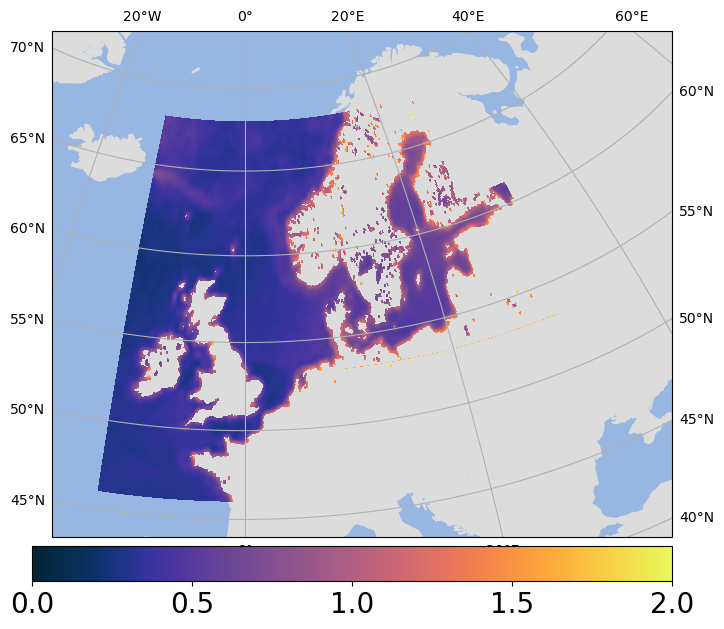

In [31]:
import cmocean as cmo
topo = xr.open_dataset("/DATASET/mbeauchamp/DMI/validation_dataset/DMI-TOPO_NSEABALTIC.nc")
fg_std = xr.open_dataset("/DATASET/mbeauchamp/DMI/validation_dataset/DMI-FGSTD_NSEABALTIC.nc")

fg_std

def plot(ax, lon, lat, data, title, cmap, norm, extent=[-65, -55, 30, 40], gridded=True, colorbar=True, orientation="horizontal", fmt=True):
    ax.set_extent(list(extent))
    if gridded:
        im=ax.pcolormesh(lon, lat, data, cmap=cmap, \
                          norm=norm, edgecolors='none', alpha=1, \
                          transform=ccrs.PlateCarree(central_longitude=0.0))
    else:
        im=ax.scatter(lon, lat, c=data, cmap=cmap, s=1, \
                       norm=norm, edgecolors='face', alpha=1, \
                       transform=ccrs.PlateCarree(central_longitude=0.0))
    #  im.set_clim(vmin,vmax)
    if colorbar==True:
        clb = plt.colorbar(im, orientation=orientation, pad=0.1, ax=ax)
        clb.set_label(title,fontsize = 25)
        clb.ax.tick_params(labelsize = 25)

    if fmt:
        gl = ax.gridlines(alpha=0.5, zorder=200,draw_labels=True)
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabels_bottom = False
        gl.ylabels_right = False
        gl.xlabel_style = {'fontsize': 10, 'rotation' : 45}
        gl.ylabel_style = {'fontsize': 10}
        
fig, ax = plt.subplots(figsize=(8,7),
                       subplot_kw=dict(projection=map_proj))
ax.add_feature(cartopy.feature.OCEAN, zorder=0)
ax.add_feature(cartopy.feature.LAND, color='gainsboro',zorder=0, edgecolor='black')
ax.set_global()
ax.gridlines(draw_labels=True)
ax.set_extent([-15, 35, 43, 71], crs=ccrs.PlateCarree())
lon_min = -10
lon_max = 30
lat_min = 48
lat_max = 66
cmap = cmo.cm.thermal
extent = [-15, 35, 43, 71]
norm = matplotlib.colors.Normalize(vmin=0, vmax=2)
plot(ax,fg_std.lon,fg_std.lat,fg_std.sat_var.values,'',extent=extent,cmap=cmap,
             norm=norm,colorbar=False,fmt=False)  
cbar_ax = fig.add_axes([0.1, 0.07, 0.8, 0.05])
cbar_ax.tick_params(labelsize=20)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal', pad=3)
cbar.ax.set_title("",fontsize=22,y=-1.5)
#plt.savefig(resfile,bbox_inches='tight')

/tmp/ipykernel_9632/4074780332.py:15: RuntimeWarning: invalid value encountered in log
  plot(ax,fg_std.lon,fg_std.lat,np.log(-1*topo.topo.values+1),'',extent=extent,cmap=cmap,


Text(0.5, -1.5, '')

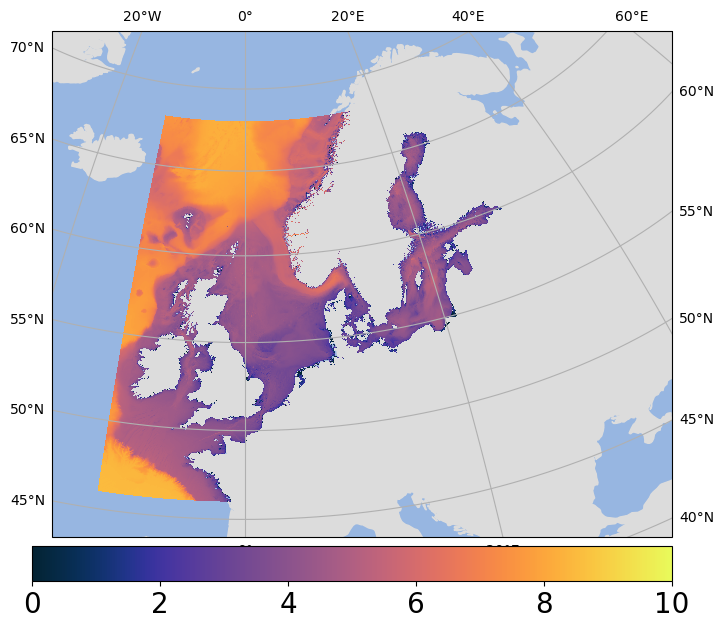

In [32]:
fig, ax = plt.subplots(figsize=(8,7),
                       subplot_kw=dict(projection=map_proj))
ax.add_feature(cartopy.feature.OCEAN, zorder=0)
ax.add_feature(cartopy.feature.LAND, color='gainsboro',zorder=0, edgecolor='black')
ax.set_global()
ax.gridlines(draw_labels=True)
ax.set_extent([-15, 35, 43, 71], crs=ccrs.PlateCarree())
lon_min = -10
lon_max = 30
lat_min = 48
lat_max = 66
cmap = cmo.cm.thermal
extent = [-15, 35, 43, 71]
norm = matplotlib.colors.Normalize(vmin=0, vmax=10)
plot(ax,fg_std.lon,fg_std.lat,np.log(-1*topo.topo.values+1),'',extent=extent,cmap=cmap,
             norm=norm,colorbar=False,fmt=False)  
cbar_ax = fig.add_axes([0.1, 0.07, 0.8, 0.05])
cbar_ax.tick_params(labelsize=20)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal', pad=3)
cbar.ax.set_title("",fontsize=22,y=-1.5)

# 2. Load the model and run

In [5]:
device = 'cuda'

from contrib.DMI.SST.solver import BaseObsCost, BilinAEPriorCost, BilinAEPriorCost_wgeo

class GradSolver(nn.Module):
    def __init__(self, prior_cost, obs_cost, grad_mod, n_step, lr_grad=0.2, **kwargs):
        super().__init__()
        self.prior_cost = prior_cost
        self.obs_cost = obs_cost
        self.grad_mod = grad_mod

        self.n_step = n_step
        self.lr_grad = lr_grad

        self._grad_norm = None

    def init_state(self, batch, x_init=None):
        if x_init is not None:
            return x_init

        return batch.input.nan_to_num().detach().requires_grad_(True)

    def solver_step(self, state, batch, step):
        var_cost = self.prior_cost(state) + self.obs_cost(state, batch)
        grad = torch.autograd.grad(var_cost, state, create_graph=True)[0]

        gmod = self.grad_mod(grad)
        state_update = (
            1 / (step + 1) * gmod
                + self.lr_grad * (step + 1) / self.n_step * grad
        )

        return state - state_update

    def forward(self, batch):
        with torch.set_grad_enabled(True):
            state = self.init_state(batch)
            self.grad_mod.reset_state(batch.input)
            states = []
            for step in range(self.n_step):
                state = self.solver_step(state, batch, step=step)
                if not self.training:
                    state = state.detach().requires_grad_(True)
                states.append(state)

        return state, states

class GradSolver_wgeo(GradSolver):

    def init_state(self, batch, x_init=None):
        x_init = super().init_state(batch, x_init)
        coords_cov = torch.stack((batch.latv[:,0].nan_to_num(),
                                  batch.lonv[:,0].nan_to_num(),
                                  batch.land_mask[:,0].nan_to_num(),
                                  batch.topo[:,0].nan_to_num(),
                                  batch.fg_std[:,0].nan_to_num()), dim=1).to(x_init.device)
        return (x_init, coords_cov)

    def solver_step(self, state, batch, step):
        var_cost = self.prior_cost(state) + self.obs_cost(state[0], batch)
        x, coords_cov = state
        grad = torch.autograd.grad(var_cost, x, create_graph=True)[0]

        x_update = (
            1 / (step + 1) * self.grad_mod(grad)
            + self.lr_grad * (step + 1) / self.n_step * grad
        )
        state = (x - x_update, coords_cov)
        return state

    def forward(self, batch):
        with torch.set_grad_enabled(True):
            state = self.init_state(batch)
            self.grad_mod.reset_state(batch.input)

            states = []
            for step in range(self.n_step):
                state = self.solver_step(state, batch, step=step)
                #state = [self.prior_cost.forward_ae(state), state[1]]
                
                if not self.training:
                    state = [s.detach().requires_grad_(True) for s in state]
                states.append(state[0])
            
            if not self.training:
                state = [self.prior_cost.forward_ae(state), state[1]]
                        
        return state[0], states

In [6]:
# state only

solver_wgeo = GradSolver_wgeo(n_step=15,
                     lr_grad=1e3,
                      prior_cost = BilinAEPriorCost_wgeo(dim_in=7,dim_hidden=64,
                                                    bilin_quad=False,downsamp=2),
                      obs_cost = BaseObsCost(),
                      grad_mod = ConvLstmGradModel(dim_in=7,dim_hidden=96)).to(device)

# state only
solver = GradSolver(n_step=15,
                     lr_grad=1e3,
                      prior_cost = BilinAEPriorCost(dim_in=7,dim_hidden=64,
                                                    bilin_quad=False,downsamp=2),
                      obs_cost = BaseObsCost(),
                      grad_mod = ConvLstmGradModel(dim_in=7,dim_hidden=96)).to(device)

## 2.1 Define the parameters (coarse)

In [37]:
from IPython.display import clear_output
from torch.optim import Adam
from tqdm.autonotebook import tqdm

rec_weight = get_last_time_wei(patch_dims =  datamodule.xrds_kw['patch_dims'],
                                 crop= {'time': 0, 'lat': 0, 'lon': 0}, offset=1)
rec_weight = torch.from_numpy(rec_weight).to(device)

optim_weight = get_linear_time_wei(patch_dims = {'time': datamodule.xrds_kw['patch_dims']['time'],
                                                'lat': datamodule.xrds_kw['patch_dims']['lat'],
                                                'lon': datamodule.xrds_kw['patch_dims']['lon']},
                                 crop= {'time': 0, 'lat': 0, 'lon': 0}, offset=1)
optim_weight = torch.from_numpy(optim_weight).to(device)

def step(batch):
    if batch.tgt.isfinite().float().mean() < 0.05:
        return None, None

    loss, out = base_step(batch)
    
    grad_loss = weighted_mse(kfilts.sobel(out) - kfilts.sobel(batch.tgt), optim_weight)
    prior_cost = solver.prior_cost(solver.init_state(batch, out))
    training_loss = 50*loss  + 10000 * grad_loss + 10 * prior_cost
    print(50*loss, 10000 * grad_loss, 10 * prior_cost)
    
    return training_loss, out

def base_step(batch):

    out = solver(batch=batch)
    # mse loss
    loss = weighted_mse(out - batch.tgt, optim_weight)
    return loss, out
    
def weighted_mse(err, weight):
    err_w = err * weight[None, ...]
    non_zeros = (torch.ones_like(err) * weight[None, ...]) == 0.0
    err_num = err.isfinite() & ~non_zeros
    if err_num.sum() == 0:
        return torch.scalar_tensor(1000.0, device=err_num.device).requires_grad_()
    loss = F.mse_loss(err_w[err_num], torch.zeros_like(err_w[err_num]))
    return loss

In [38]:
ckpt = torch.load('/homes/m19beauc/4dvarnet-starter/ckpt/DMI/SST/sst_dmi_baltic_rzf10.ckpt', map_location=device)
solver_weights = {k[7:]: v for k, v in ckpt["state_dict"].items() if k.startswith("solver.")}
solver.load_state_dict(solver_weights)

<All keys matched successfully>

In [39]:
k=1
test_batch = next(itertools.islice(test_dataloader_coarse, k, None))
test_batch_ = test_batch
test_batch_ = test_batch_._replace(input=test_batch_.input.nan_to_num().to(device))
test_batch_ = test_batch_._replace(tgt=test_batch_.tgt.nan_to_num().to(device))
"""
test_batch_ = test_batch_._replace(lat=test_batch_.lat.nan_to_num().to(device))
test_batch_ = test_batch_._replace(lon=test_batch_.lon.nan_to_num().to(device))
test_batch_ = test_batch_._replace(mask=test_batch_.mask.nan_to_num().to(device))
"""
# 4DVarNets scheme  
out = solver(test_batch_)

/tmp/ipykernel_3114915/2140991752.py:19: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  mappable = p.axes[0][0].collections[0]
/tmp/ipykernel_3114915/2140991752.py:25: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in p.axes.flat:


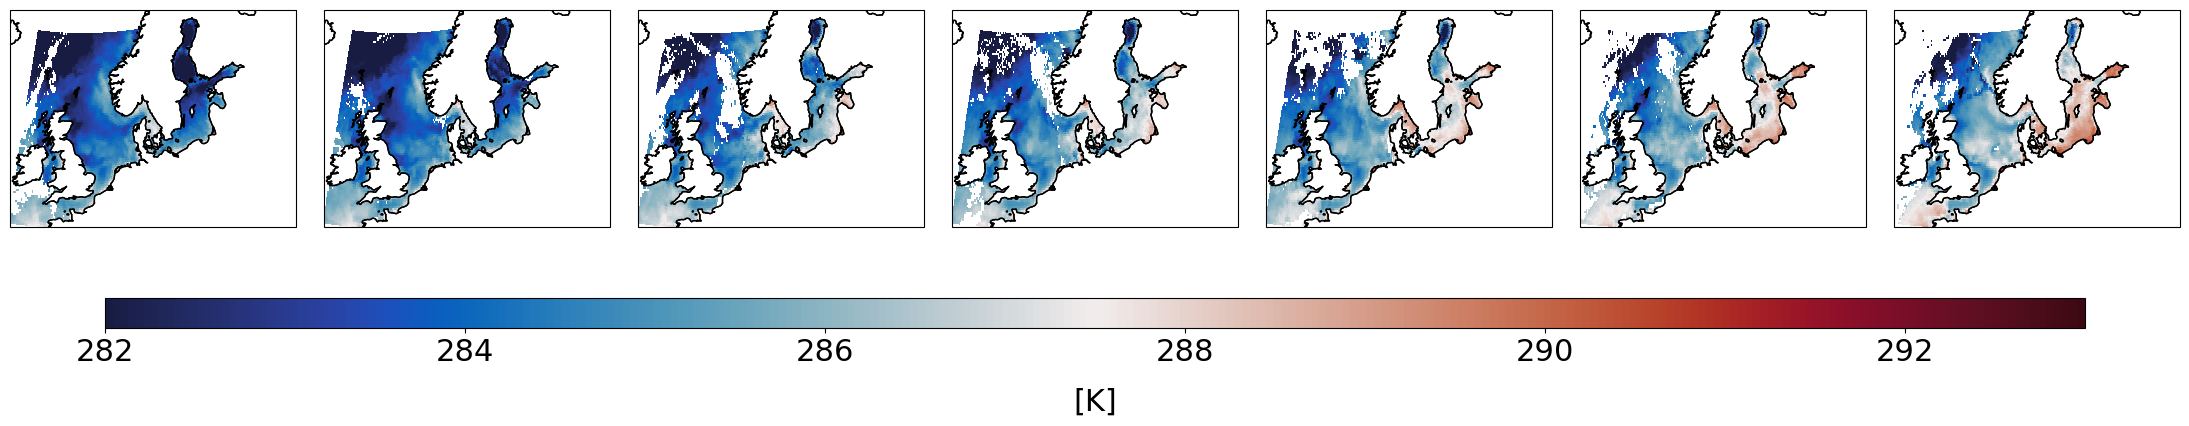

In [40]:
import cmocean as cmo
coords = datamodule_coarse.test_ds.get_coords()
m, s = [283.8052,4.2381434]
solver_steps = torch.stack(out[1],dim=0).detach().cpu().numpy()*s+m
solver_steps[0] = test_batch.input.detach().cpu().numpy()*s+m
# datamodule.train_ds[0].input has shape (15, 240, 240)
#plt.figure(figsize=(30,20))
p = xr.Dataset(data_vars={'sst':(('time','lat','lon'),test_batch.input[0,:,:,:].detach().cpu().numpy()*s+m)},
           coords={'time':np.arange(7),
                   'lon':coords[2*k].lon,
                   'lat':coords[2*k].lat}).sst.plot(transform=ccrs.PlateCarree(),
                                                   col='time',col_wrap=7,
                                                   vmin=282, vmax=293,
                                                   cmap=cmo.cm.balance,
                                                   #aspect=datamodule.input_da.dims['lon'] / datamodule.input_da.dims['lat'], 
                                                   #subplot_kws={'projection': ccrs.Orthographic(0, 45)})
                                                   subplot_kws={'projection': map_proj},
                                                   add_colorbar=False)
mappable = p.axes[0][0].collections[0]
cax = plt.axes([0.05, -0.2, 0.9, 0.1])
cbar1 = plt.colorbar(mappable, cax=cax, orientation='horizontal')
cbar1.ax.tick_params(labelsize=22,axis="both")
cbar1.ax.set_title("[K]",fontsize=22,y=-3)

for ax in p.axes.flat:
    ax.set_title('')
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_xlabel('')
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_ylabel('')
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black',facecolor="white")
    ax.set_global()
    #ax.gridlines(draw_labels=True)
    ax.set_extent([np.min(coords[2*k].lon), 
                   np.max(coords[2*k].lon), 
                   np.min(coords[2*k].lat), 
                   np.max(coords[2*k].lat)], crs=ccrs.PlateCarree())
plt.subplots_adjust(wspace=0.1)


/tmp/ipykernel_3114915/137186188.py:20: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  mappable = p.axes[0][0].collections[0]
/tmp/ipykernel_3114915/137186188.py:27: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in p.axes.flat:


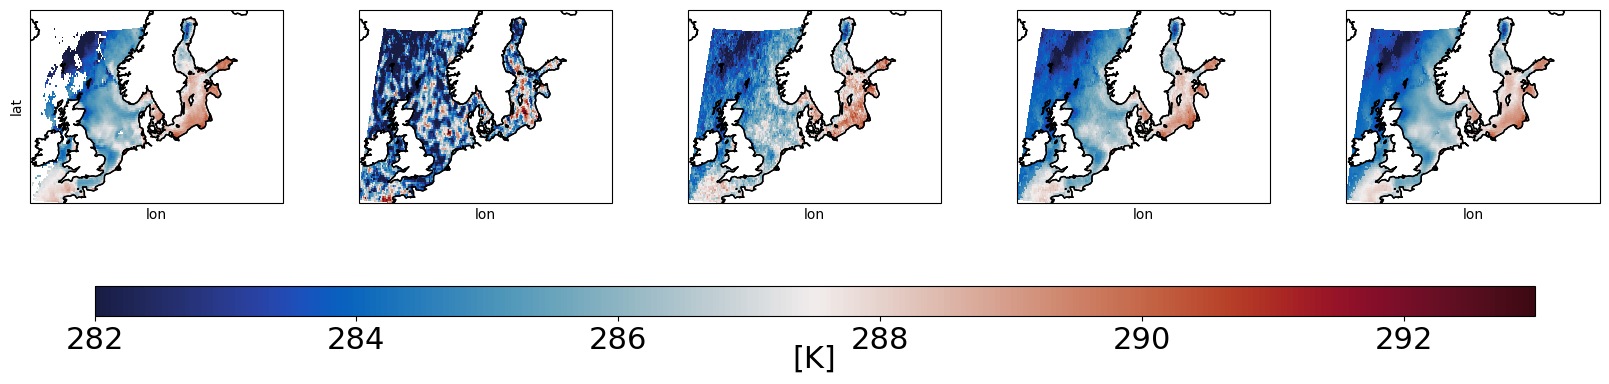

In [43]:
coords = datamodule_coarse.test_ds.get_coords()
m, s = [283.8052,4.2381434]
solver_steps = torch.stack(out[1],dim=0).detach().cpu().numpy()*s+m
solver_steps[0] = test_batch.input.detach().cpu().numpy()*s+m
#solver_steps[:,:,:,0:100,:] = np.nan
#solver_steps[:,:,:,:,0:50] = np.nan

p = xr.Dataset(data_vars={'sst':(('steps','lat','lon'),solver_steps[[0,1,4,8,14],0,6,:,:])},
           coords={'steps':np.arange(5),
                   'lon':coords[2*k].lon,
                   'lat':coords[2*k].lat}).sst.plot(transform=ccrs.PlateCarree(),
                                                   col='steps',col_wrap=5,
                                                   vmin=282, vmax=293,
                                                   cmap=cmo.cm.balance,
                                                   #aspect=datamodule.input_da.dims['lon'] / datamodule.input_da.dims['lat'], 
                                                   #subplot_kws={'projection': ccrs.Orthographic(0, 45)})
                                                   subplot_kws={'projection': map_proj},
                                                   add_colorbar=False)

mappable = p.axes[0][0].collections[0]
cax = plt.axes([0.05, -0.2, 0.9, 0.1])
cbar1 = plt.colorbar(mappable, cax=cax, orientation='horizontal')
cbar1.ax.tick_params(labelsize=22,axis="both")
cbar1.ax.set_title("[K]",fontsize=22,y=-2)

plt.subplots_adjust(wspace=.3,hspace=.3)
for ax in p.axes.flat:
    ax.set_title('')
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black',facecolor="white")
    ax.set_global()
    #ax.gridlines(draw_labels=True)
    ax.set_extent([np.min(coords[2*k].lon), 
                   np.max(coords[2*k].lon), 
                   np.min(coords[2*k].lat), 
                   np.max(coords[2*k].lat)], crs=ccrs.PlateCarree())

## 2.2 Define the parameters (anom)

In [7]:
from IPython.display import clear_output
from torch.optim import Adam
from tqdm.autonotebook import tqdm

rec_weight = get_last_time_wei(patch_dims =  datamodule.xrds_kw['patch_dims'],
                                 crop= {'time': 0, 'lat': 20, 'lon': 20}, offset=1)
rec_weight = torch.from_numpy(rec_weight).to(device)

optim_weight = get_linear_time_wei(patch_dims = {'time': datamodule.xrds_kw['patch_dims']['time'],
                                                'lat': datamodule.xrds_kw['patch_dims']['lat'],
                                                'lon': datamodule.xrds_kw['patch_dims']['lon']},
                                 crop= {'time': 0, 'lat': 20, 'lon': 20}, offset=1)
optim_weight = torch.from_numpy(optim_weight).to(device)

def step(batch):
    if batch.tgt.isfinite().float().mean() < 0.05:
        return None, None

    loss, out = base_step(batch)
    
    grad_loss = weighted_mse(kfilts.sobel(out) - kfilts.sobel(batch.tgt), optim_weight)
    prior_cost = solver.prior_cost(solver.init_state(batch, out))
    training_loss = 50*loss  + 10000 * grad_loss + 10 * prior_cost
    print(50*loss, 10000 * grad_loss, 10 * prior_cost)
    
    return training_loss, out

def base_step(batch):

    out = solver(batch=batch)
    # mse loss
    loss = weighted_mse(out - batch.tgt, optim_weight)
    return loss, out
    
def weighted_mse(err, weight):
    err_w = err * weight[None, ...]
    non_zeros = (torch.ones_like(err) * weight[None, ...]) == 0.0
    err_num = err.isfinite() & ~non_zeros
    if err_num.sum() == 0:
        return torch.scalar_tensor(1000.0, device=err_num.device).requires_grad_()
    loss = F.mse_loss(err_w[err_num], torch.zeros_like(err_w[err_num]))
    return loss

In [12]:
ckpt = torch.load('/homes/m19beauc/4dvarnet-starter/ckpt/DMI/sst_dmi_baltic_wcoarse_wgeo.ckpt', map_location=device)
solver_weights = {k[7:]: v for k, v in ckpt["state_dict"].items() if k.startswith("solver.")}
solver_wgeo.load_state_dict(solver_weights)

<All keys matched successfully>

In [13]:
k=30
test_batch = next(itertools.islice(test_dataloader, k, None))
test_batch_ = test_batch
#test_batch_ = test_batch_._replace(input=test_batch_.input.nan_to_num().to(device))
#test_batch_ = test_batch_._replace(tgt=test_batch_.tgt.nan_to_num().to(device))
"""
test_batch_ = test_batch_._replace(lat=test_batch_.lat.nan_to_num().to(device))
test_batch_ = test_batch_._replace(lon=test_batch_.lon.nan_to_num().to(device))
test_batch_ = test_batch_._replace(mask=test_batch_.mask.nan_to_num().to(device))
"""
test_batch_ = test_batch_._replace(input=test_batch_.input.to(device))
test_batch_ = test_batch_._replace(tgt=test_batch_.tgt.to(device))
# 4DVarNets scheme  
out = solver_wgeo(test_batch_)

RuntimeError: CUDA out of memory. Tried to allocate 170.00 MiB (GPU 0; 79.14 GiB total capacity; 11.91 GiB already allocated; 28.12 MiB free; 12.27 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

/tmp/ipykernel_173170/2243952425.py:19: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  mappable = p.axes[0][0].collections[0]
/tmp/ipykernel_173170/2243952425.py:25: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in p.axes.flat:


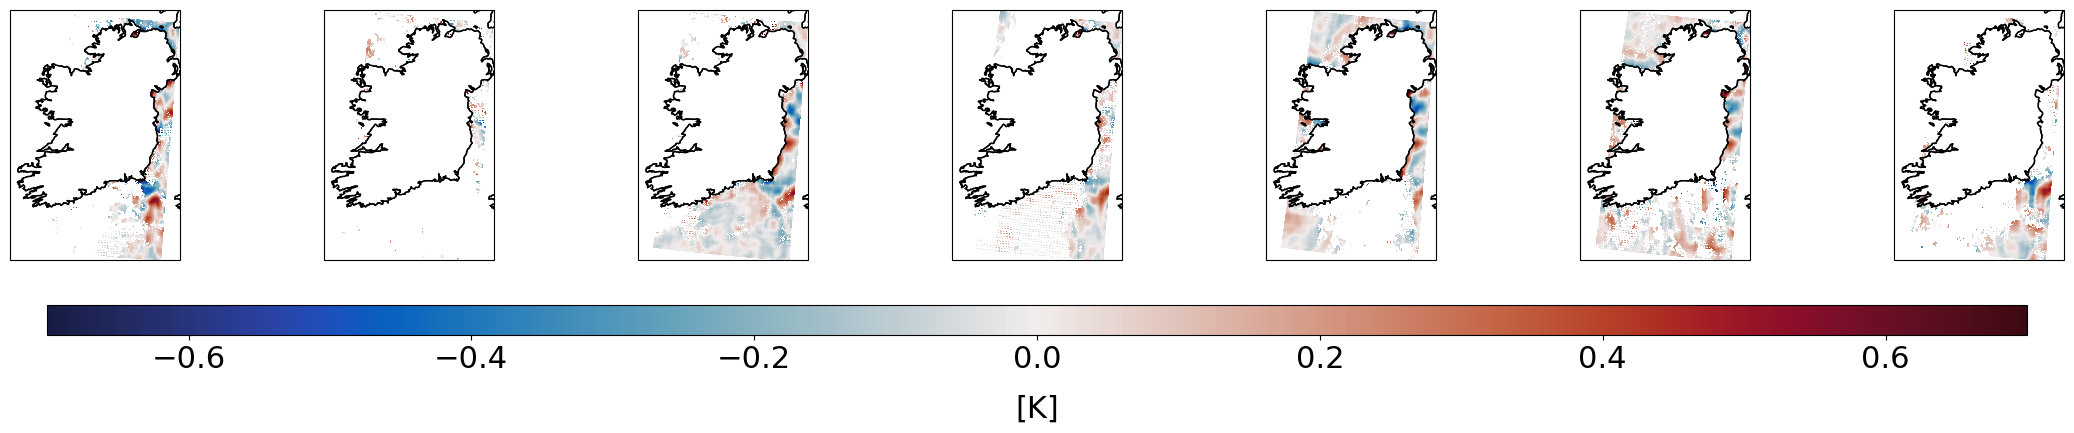

In [11]:
import cmocean as cmo 
coords = datamodule.test_ds.get_coords()
m, s = [-0.015420883207237286,0.4562528584789277]
solver_steps = torch.stack(out[1],dim=0).detach().cpu().numpy()*s+m
solver_steps[0] = test_batch.input.detach().cpu().numpy()*s+m
# datamodule.train_ds[0].input has shape (15, 240, 240)
#plt.figure(figsize=(30,20))
p = xr.Dataset(data_vars={'sst':(('time','lat','lon'),test_batch.input[0,:,:,:].detach().cpu().numpy()*s+m)},
           coords={'time':np.arange(7),
                   'lon':coords[2*k].lon,
                   'lat':coords[2*k].lat}).sst.plot(transform=ccrs.PlateCarree(),
                                                   col='time',col_wrap=7,
                                                   vmin=-.7, vmax=.7,
                                                   cmap=cmo.cm.balance,
                                                   #aspect=datamodule.input_da.dims['lon'] / datamodule.input_da.dims['lat'], 
                                                   #subplot_kws={'projection': ccrs.Orthographic(0, 45)})
                                                   subplot_kws={'projection': map_proj},
                                                   add_colorbar=False)
mappable = p.axes[0][0].collections[0]
cax = plt.axes([0.05, -0.2, 0.9, 0.1])
cbar1 = plt.colorbar(mappable, cax=cax, orientation='horizontal')
cbar1.ax.tick_params(labelsize=22,axis="both")
cbar1.ax.set_title("[K]",fontsize=22,y=-3)

for ax in p.axes.flat:
    ax.set_title('')
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_xlabel('')
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_ylabel('')
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black',facecolor="white")
    ax.set_global()
    #ax.gridlines(draw_labels=True)
    ax.set_extent([np.min(coords[2*k].lon), 
                   np.max(coords[2*k].lon), 
                   np.min(coords[2*k].lat), 
                   np.max(coords[2*k].lat)], crs=ccrs.PlateCarree())
plt.subplots_adjust(wspace=0.1)

/tmp/ipykernel_173170/2755960033.py:21: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  mappable = p.axes[0][0].collections[0]
/tmp/ipykernel_173170/2755960033.py:28: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in p.axes.flat:


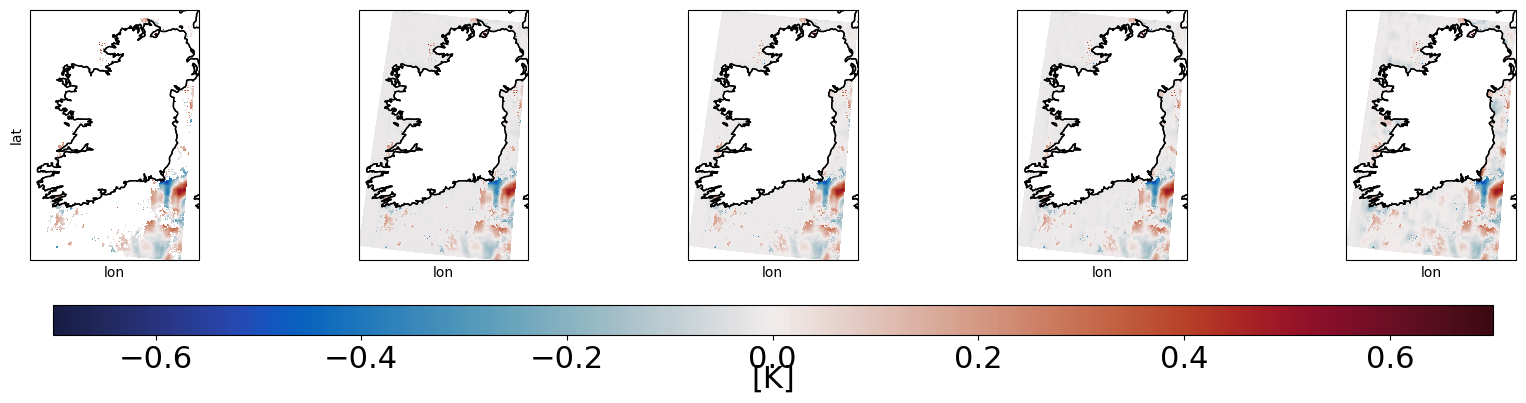

In [10]:
import cmocean as cmo
coords = datamodule.test_ds.get_coords()
m, s = [-0.015420883207237286,0.4562528584789277]
solver_steps = torch.stack(out[1],dim=0).detach().cpu().numpy()*s+m
solver_steps[0] = test_batch.input.detach().cpu().numpy()*s+m
#solver_steps[:,:,:,0:100,:] = np.nan
#solver_steps[:,:,:,:,0:50] = np.nan

p = xr.Dataset(data_vars={'sst':(('steps','lat','lon'),solver_steps[[0,1,4,8,14],0,6,:,:])},
           coords={'steps':np.arange(5),
                   'lon':coords[2*k].lon,
                   'lat':coords[2*k].lat}).sst.plot(transform=ccrs.PlateCarree(),
                                                   col='steps',col_wrap=5,
                                                   vmin=-.7, vmax=.7,
                                                   cmap=cmo.cm.balance,
                                                   #aspect=datamodule.input_da.dims['lon'] / datamodule.input_da.dims['lat'], 
                                                   #subplot_kws={'projection': ccrs.Orthographic(0, 45)})
                                                   subplot_kws={'projection': map_proj},
                                                   add_colorbar=False)

mappable = p.axes[0][0].collections[0]
cax = plt.axes([0.05, -0.2, 0.9, 0.1])
cbar1 = plt.colorbar(mappable, cax=cax, orientation='horizontal')
cbar1.ax.tick_params(labelsize=22,axis="both")
cbar1.ax.set_title("[K]",fontsize=22,y=-2)

plt.subplots_adjust(wspace=.3,hspace=.3)
for ax in p.axes.flat:
    ax.set_title('')
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black',facecolor="white")
    ax.set_global()
    #ax.gridlines(draw_labels=True)
    ax.set_extent([np.min(coords[2*k].lon), 
                   np.max(coords[2*k].lon), 
                   np.min(coords[2*k].lat), 
                   np.max(coords[2*k].lat)], crs=ccrs.PlateCarree())

In [14]:
obs = xr.open_dataset("/DATASET/mbeauchamp/DMI/validation_dataset/DMI-L3S_GHRSST-SSTsubskin-night_SST_UHR_NRT-NSEABALTIC_validation_s0.nc")
obs = obs.sel(time=coords[2*k].time)
oi = xr.open_dataset("/DATASET/mbeauchamp/DMI/validation_dataset/DMI-L4_GHRSST-SSTfnd-DMI_OI-NSEABALTIC_2021_validation.nc")
oi = oi.sel(time=coords[2*k].time)
oi_coarse = oi.coarsen(lon=10,boundary="trim").mean().coarsen(lat=10,boundary="trim").mean()
new_lon = oi.lon
new_lat = oi.lat
oi_coarse = oi_coarse.interp(lon=new_lon,lat=new_lat)

In [19]:
new_lon = coords[2*k].lon
new_lat = coords[2*k].lat
obs_batch = obs.interp(lon=new_lon,lat=new_lat)
oi_batch = oi.interp(lon=new_lon,lat=new_lat)
oi_coarse_batch = oi_coarse.interp(lon=new_lon,lat=new_lat)
obs_anom_batch = obs_batch.sea_surface_temperature-oi_coarse_batch.analysed_sst

/tmp/ipykernel_3591549/4133491034.py:14: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  mappable = p.axes[0][0].collections[0]
/tmp/ipykernel_3591549/4133491034.py:20: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in p.axes.flat:


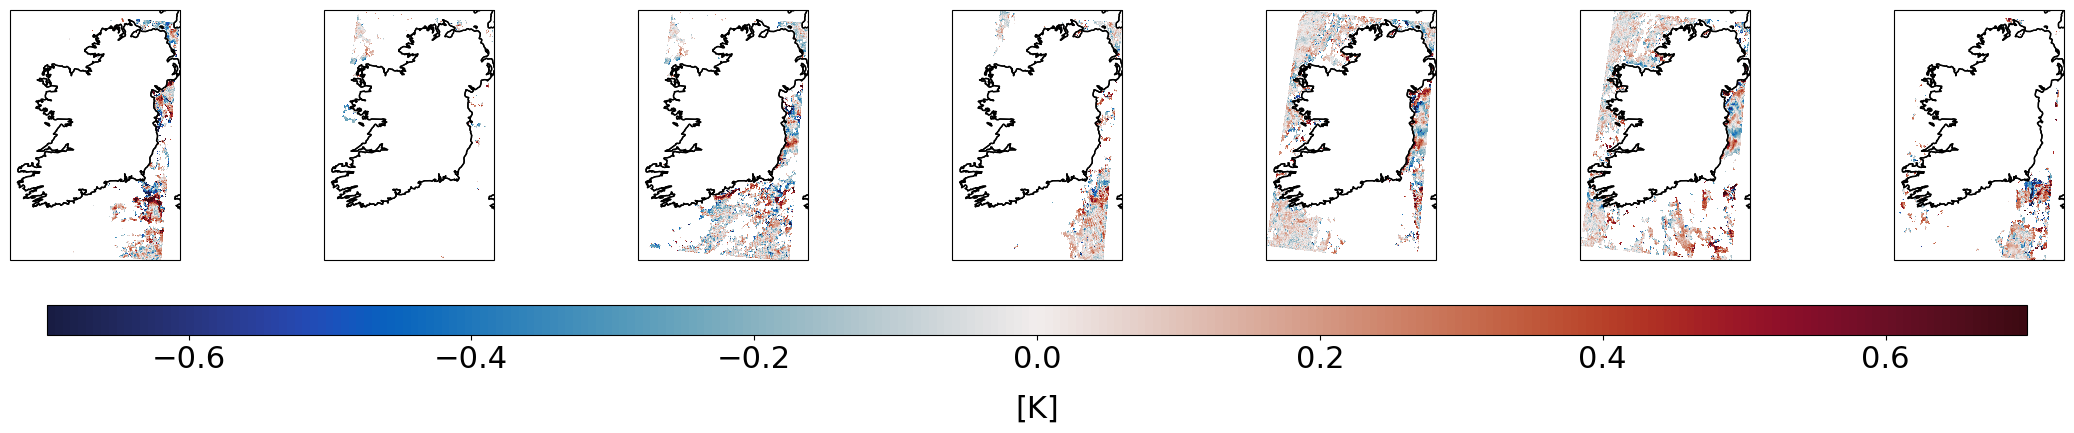

In [21]:
import cmocean as cmo 
coords = datamodule.test_ds.get_coords()
p = xr.Dataset(data_vars={'sst':(('time','lat','lon'),obs_anom_batch.data)},
           coords={'time':np.arange(7),
                   'lon':coords[2*k].lon,
                   'lat':coords[2*k].lat}).sst.plot(transform=ccrs.PlateCarree(),
                                                   col='time',col_wrap=7,
                                                   vmin=-.7, vmax=.7,
                                                   cmap=cmo.cm.balance,
                                                   #aspect=datamodule.input_da.dims['lon'] / datamodule.input_da.dims['lat'], 
                                                   #subplot_kws={'projection': ccrs.Orthographic(0, 45)})
                                                   subplot_kws={'projection': map_proj},
                                                   add_colorbar=False)
mappable = p.axes[0][0].collections[0]
cax = plt.axes([0.05, -0.2, 0.9, 0.1])
cbar1 = plt.colorbar(mappable, cax=cax, orientation='horizontal')
cbar1.ax.tick_params(labelsize=22,axis="both")
cbar1.ax.set_title("[K]",fontsize=22,y=-3)

for ax in p.axes.flat:
    ax.set_title('')
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_xlabel('')
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_ylabel('')
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black',facecolor="white")
    ax.set_global()
    #ax.gridlines(draw_labels=True)
    ax.set_extent([np.min(coords[2*k].lon), 
                   np.max(coords[2*k].lon), 
                   np.min(coords[2*k].lat), 
                   np.max(coords[2*k].lat)], crs=ccrs.PlateCarree())
plt.subplots_adjust(wspace=0.1)

/tmp/ipykernel_3591549/166761381.py:14: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  mappable = p.axes[0][0].collections[0]
/tmp/ipykernel_3591549/166761381.py:20: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in p.axes.flat:


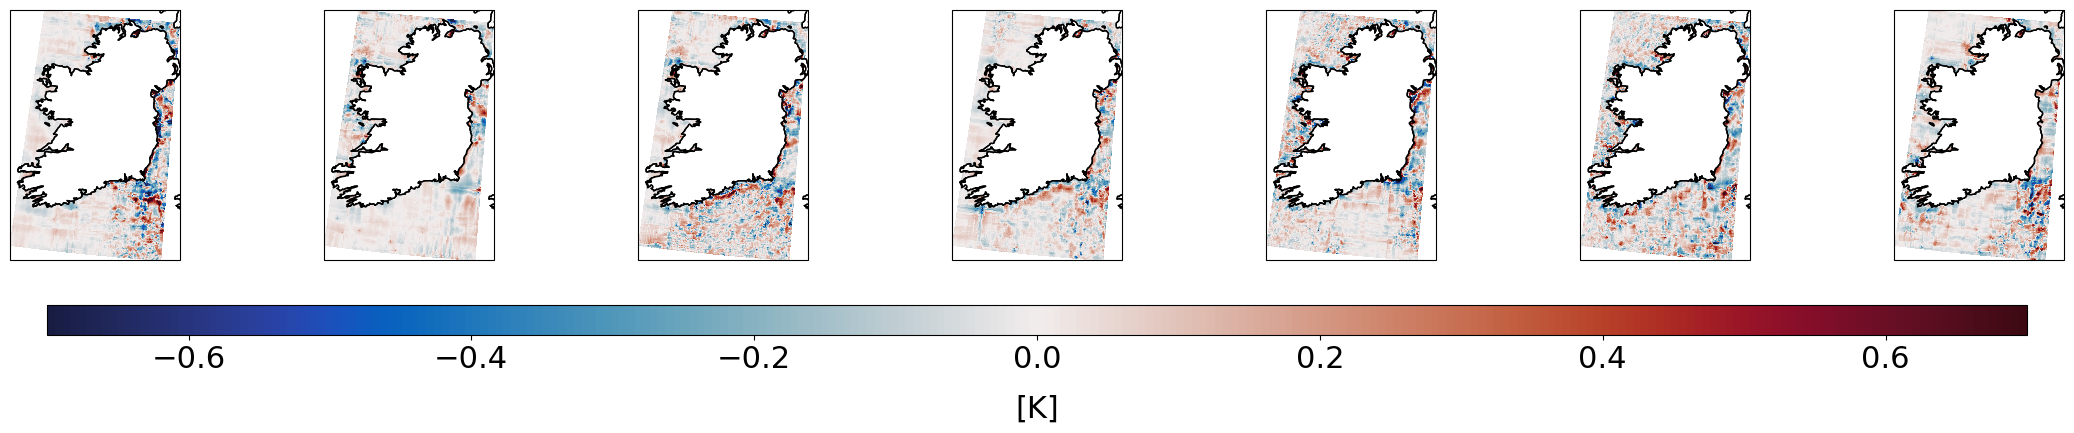

In [22]:
import cmocean as cmo 
coords = datamodule.test_ds.get_coords()
p = xr.Dataset(data_vars={'sst':(('time','lat','lon'),(oi_batch-oi_coarse_batch).analysed_sst.data)},
           coords={'time':np.arange(7),
                   'lon':coords[2*k].lon,
                   'lat':coords[2*k].lat}).sst.plot(transform=ccrs.PlateCarree(),
                                                   col='time',col_wrap=7,
                                                   vmin=-.7, vmax=.7,
                                                   cmap=cmo.cm.balance,
                                                   #aspect=datamodule.input_da.dims['lon'] / datamodule.input_da.dims['lat'], 
                                                   #subplot_kws={'projection': ccrs.Orthographic(0, 45)})
                                                   subplot_kws={'projection': map_proj},
                                                   add_colorbar=False)
mappable = p.axes[0][0].collections[0]
cax = plt.axes([0.05, -0.2, 0.9, 0.1])
cbar1 = plt.colorbar(mappable, cax=cax, orientation='horizontal')
cbar1.ax.tick_params(labelsize=22,axis="both")
cbar1.ax.set_title("[K]",fontsize=22,y=-3)

for ax in p.axes.flat:
    ax.set_title('')
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_xlabel('')
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_ylabel('')
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black',facecolor="white")
    ax.set_global()
    #ax.gridlines(draw_labels=True)
    ax.set_extent([np.min(coords[2*k].lon), 
                   np.max(coords[2*k].lon), 
                   np.min(coords[2*k].lat), 
                   np.max(coords[2*k].lat)], crs=ccrs.PlateCarree())
plt.subplots_adjust(wspace=0.1)

## 2.2 Run test dataset, output NetCDF and metrics

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

def run_test(test_dataloader):

    test_data = []

    def test_quantities(self):
        return ['inp', 'tgt', 'out']

    m, s = [283.8052,4.2381434] 

    for k in range(len(test_dataloader)):
    
        print(str(k)+'/'+str(len(test_dataloader)))
        test_batch = next(itertools.islice(test_dataloader, k, None))
        
        test_batch_ = test_batch
        test_batch_ = test_batch_._replace(input=test_batch_.input.nan_to_num().to(device))
        test_batch_ = test_batch_._replace(tgt=test_batch_.tgt.nan_to_num().to(device))
        
        # 4DVarNets scheme  
        out = solver(test_batch_)
    
        test_data.append(torch.stack(
        [
            test_batch_.input.detach().cpu() * s + m,
            test_batch_.tgt.detach().cpu() * s + m,
            out.squeeze(dim=-1).detach().cpu() * s + m,
        ],
        dim=1,
        )) 
        
        test_batch_ = None
        out = None
        gc.collect()
        torch.cuda.empty_cache()

    # reconstruct mean
    if isinstance(test_dataloader,list):
        rec_da = test_dataloader[0].dataset.reconstruct(
            test_data, rec_weight.cpu().numpy()
        )
    else:
        rec_da = test_dataloader.dataset.reconstruct(
                test_data, rec_weight.cpu().numpy()
        )
    rec_da = test_dataloader.dataset.reconstruct(test_data, rec_weight.cpu().numpy())
    test_data = rec_da.assign_coords(
            dict(v0=test_quantities)
        ).to_dataset(dim='v0')

    return test_data

In [ ]:
import os 
test_data = run_test(test_dataloader)
file = "/DATASET/mbeauchamp/DMI/4DVarNet_outputs/DMI-L4_GHRSST-SSTfnd-DMI_4DVarNet-NSEABALTIC_2021_all_baltic_wgeo_linweight_dt15_all.nc"
if not os.path.isfile(file):
    test_data = run_test(test_dataloader)
    test_data.to_netcdf(file)

In [ ]:
file = "/DATASET/mbeauchamp/DMI/4DVarNet_outputs/DMI-L4_GHRSST-SSTfnd-DMI_4DVarNet-NSEABALTIC_2021_all_baltic_wgeo_linweight_dt15_dm1.nc"
if not os.path.isfile(file):
    test_data_dm1 = run_test(test_dataloader_dm1)
    test_data_dm1.to_netcdf(file)

In [ ]:
file = "/DATASET/mbeauchamp/DMI/4DVarNet_outputs/DMI-L4_GHRSST-SSTfnd-DMI_4DVarNet-NSEABALTIC_2021_all_baltic_wgeo_linweight_dt15_dm2.nc"
if not os.path.isfile(file):
    test_data_dm2 = run_test(test_dataloader_dm2)
    test_data_dm2.to_netcdf(file)

In [ ]:
file = "/DATASET/mbeauchamp/DMI/4DVarNet_outputs/DMI-L4_GHRSST-SSTfnd-DMI_4DVarNet-NSEABALTIC_2021_all_baltic_wgeo_linweight_dt15_dm3.nc"
if not os.path.isfile(file):
    test_data_dm3 = run_test(test_dataloader_dm3)
    test_data_dm3.to_netcdf(file)

# 3. Plot the metrics

In [ ]:
test_data.out.plot(col="time",col_wrap=5)
! python /DATASET/mbeauchamp/DMI/codes/plot_metrics.py all_baltic_wgeo_linweight_dt15
! python /DATASET/mbeauchamp/DMI/codes/plot_metrics.py all_baltic_wgeo_linweight_dt15_dm1
! python /DATASET/mbeauchamp/DMI/codes/plot_metrics.py all_baltic_wgeo_linweight_dt15_dm2
! python /DATASET/mbeauchamp/DMI/codes/plot_metrics.py all_baltic_wgeo_linweight_dt15_dm3